In [1]:
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import torch
from treeinterpreter import treeinterpreter as ti
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# Visualizing feature contribution for ChemPhys

In [3]:
def get_feature_imp(model, test_data):
    # time consuming step
    prediction, bias, contributions = ti.predict(model, test_data)

    cols = test_data.columns.tolist()
    model_labels = model.classes_.tolist()

    feature_imp_list = defaultdict(lambda: defaultdict(list))

    for i in tqdm(contributions):
        for feature_name, feature_value in zip(cols, i):
            for label, value in zip(model_labels, feature_value):
                feature_imp_list[label][feature_name].append(value)

    feature_imp_median_list = {
        label: {
            feature: sorted(values)[len(values) // 2]
            for feature, values in features.items()
        }
        for label, features in feature_imp_list.items()
    }
    feature_imp_median_df = pd.DataFrame(feature_imp_median_list)
    return feature_imp_median_df

In [4]:
chemphys_model = torch.load(f"../models/combined/chem_phys_rf.pkl")
chemphys_test_data = pd.read_csv(f"../data/splits/combined/chem_phys_test.csv")
chemphys_test_data.drop(columns=["cmp_id"], inplace=True)
X_chemphys_test, y_chemphys_test = (
    chemphys_test_data.drop("label", axis=1),
    chemphys_test_data["label"],
)

In [5]:
feature_imp_median_df = get_feature_imp(model=chemphys_model, test_data=X_chemphys_test)
feature_imp_median_df.head(2)

100%|██████████| 14841/14841 [00:00<00:00, 65916.02it/s]


,acid-fast,fungi,gram-negative,gram-positive,inactive
slogp,-0.002604,-0.000526,-0.017539,0.002128,-0.001382
smr,-0.004077,-0.003592,-0.003915,0.000801,-0.001862


In [6]:
# min-max scale the feature importances
feature_imp_median_df = (feature_imp_median_df - feature_imp_median_df.min()) / (
    feature_imp_median_df.max() - feature_imp_median_df.min()
)

In [7]:
importance = chemphys_model.feature_importances_
all_feature_importance = pd.DataFrame(
    {"feature": X_chemphys_test.columns, "importance": importance}
)
all_feature_importance = all_feature_importance.sort_values(
    by="importance", ascending=False
)

In [8]:
k = feature_imp_median_df.copy(deep=True)

# reorder index based on all_feature_importance
k = k.reindex(all_feature_importance["feature"].tolist())

<Figure size 2000x1000 with 0 Axes>

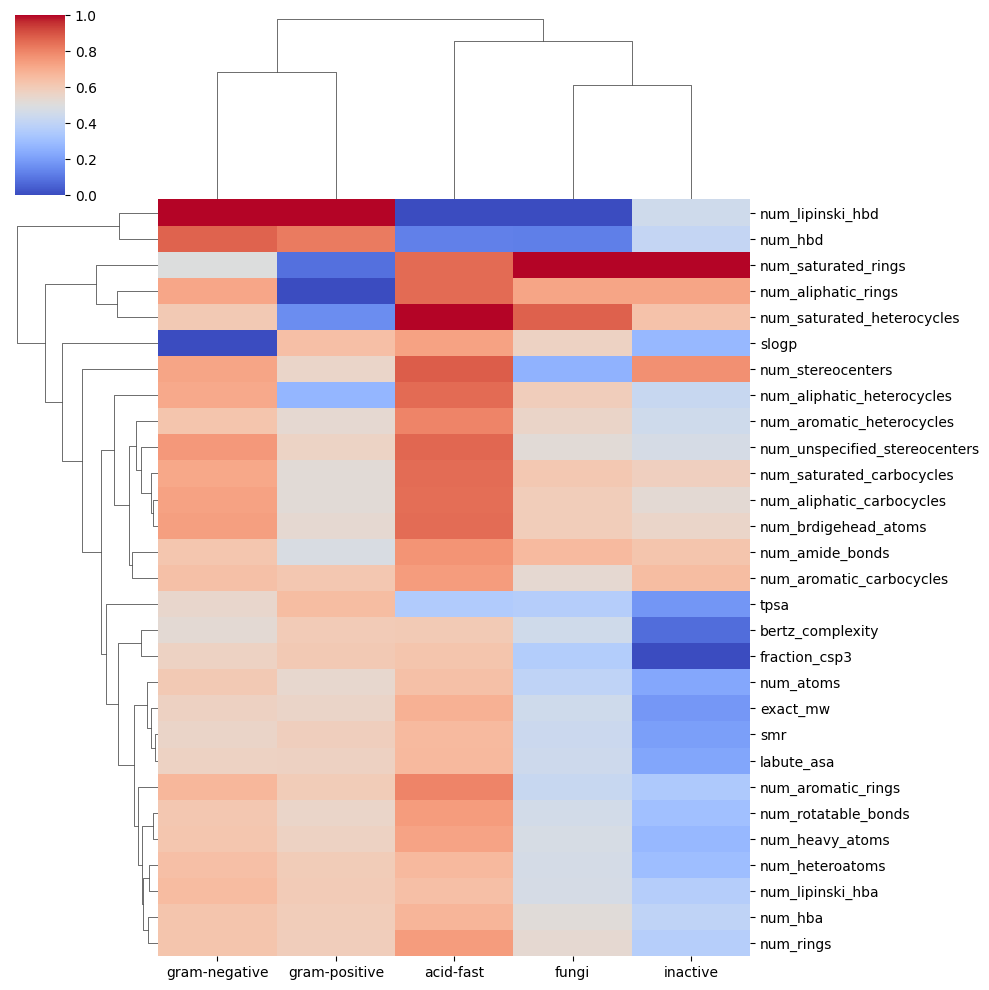

In [9]:
# draw the heatmap for the feature importance
plt.figure(figsize=(20, 10))
sns.clustermap(k, cmap="coolwarm")
plt.savefig("../figures/figure_7.png", dpi=400)
plt.show()

# Visualizing feature contribution for MHFP

In [10]:
mhfp6_model = torch.load(f"../models/combined/mhfp6_rf.pkl")
mhfp6_test_data = pd.read_csv(f"../data/splits/combined/mhfp6_test.csv")
mhfp6_test_data.drop(columns=["cmp_id"], inplace=True)
X_mhfp6_test, y_mhfp6_test = (
    mhfp6_test_data.drop("label", axis=1),
    mhfp6_test_data["label"],
)

In [11]:
feature_imp_median_df = get_feature_imp(model=mhfp6_model, test_data=X_mhfp6_test)
feature_imp_median_df.head(2)

100%|██████████| 14841/14841 [00:16<00:00, 881.75it/s]


,acid-fast,fungi,gram-negative,gram-positive,inactive
bit0,0.000000,0.000000,0.00000,0.000004,0.0
bit1,-0.000013,-0.000077,0.00001,0.000000,0.0


In [12]:
# min-max scale the feature importances
feature_imp_median_df = (feature_imp_median_df - feature_imp_median_df.min()) / (
    feature_imp_median_df.max() - feature_imp_median_df.min()
)

<Figure size 2000x1000 with 0 Axes>

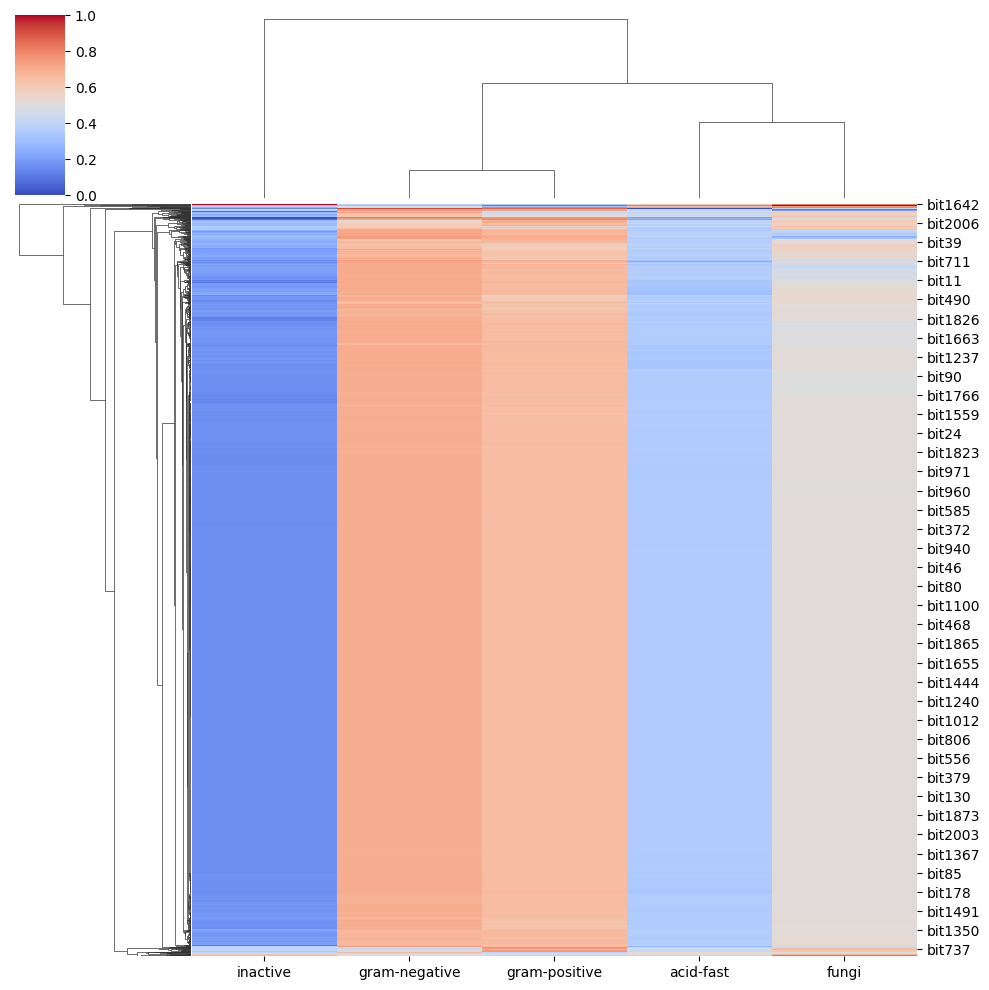

In [13]:
# draw the heatmap for the feature importance
plt.figure(figsize=(20, 10))
sns.clustermap(feature_imp_median_df, cmap="coolwarm")
plt.savefig("../figures/supplementary_figure_4.png", dpi=400)
plt.show()

# Deeper inspection

In [14]:
importance = mhfp6_model.feature_importances_
all_feature_importance = pd.DataFrame(
    {"feature": X_mhfp6_test.columns, "importance": importance}
)
all_feature_importance = all_feature_importance.sort_values(
    by="importance", ascending=False
)
all_feature_importance.head(2)

,feature,importance
1642,bit1642,0.003003
1668,bit1668,0.001848


In [15]:
k = feature_imp_median_df.copy(deep=True)

# reorder index based on all_feature_importance
k = k.reindex(all_feature_importance["feature"].tolist())

<Figure size 2000x1000 with 0 Axes>

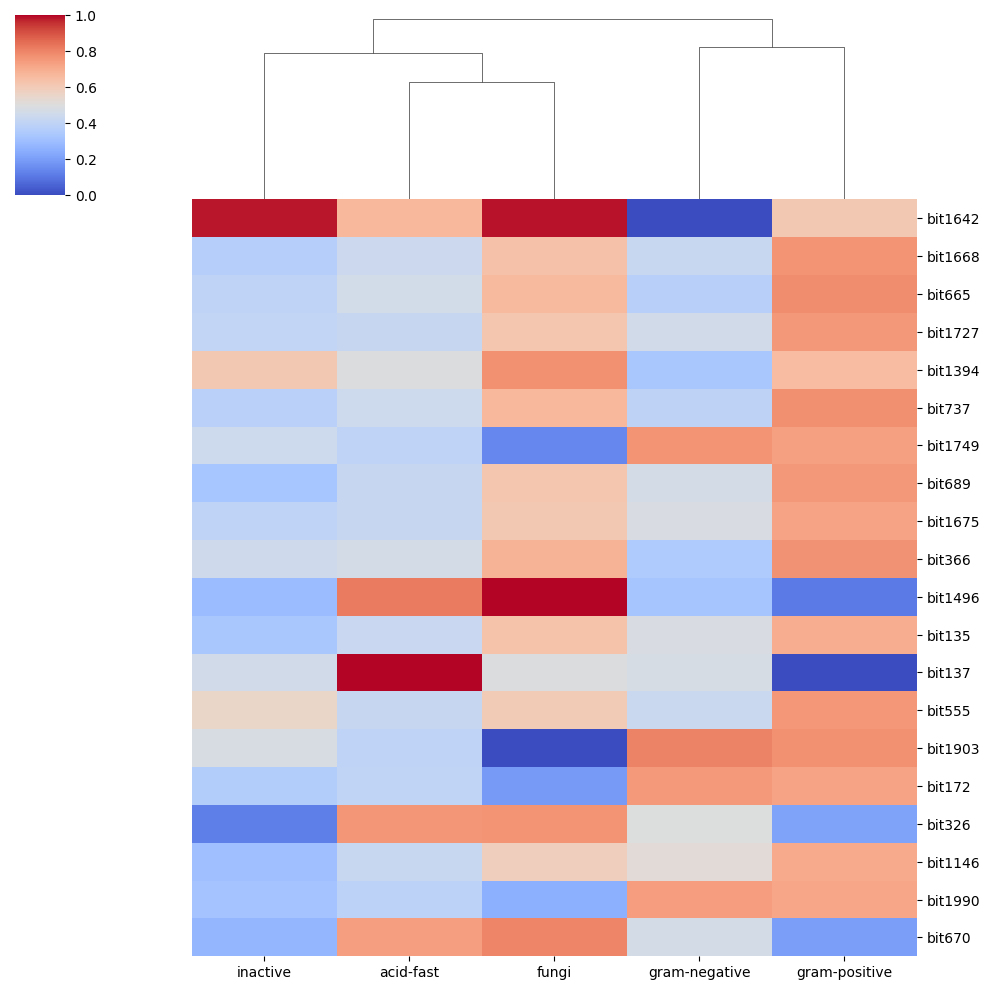

In [16]:
# draw the heatmap for the feature importance
plt.figure(figsize=(20, 10))
sns.clustermap(k.head(20), cmap="coolwarm", row_cluster=False)
plt.show()

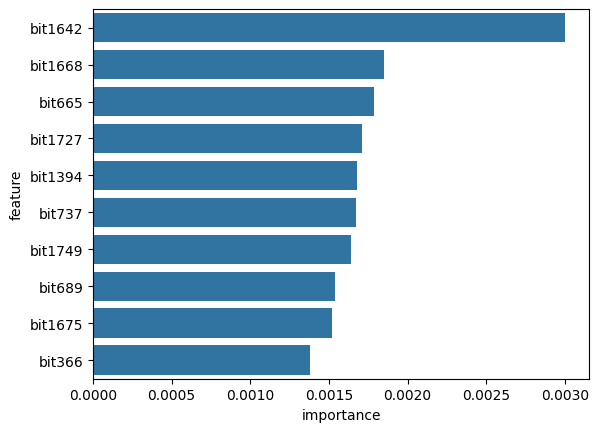

In [17]:
importance = mhfp6_model.feature_importances_
feature_importance = pd.DataFrame(
    {"feature": X_mhfp6_test.columns, "importance": importance}
)
feature_importance = feature_importance.sort_values("importance", ascending=False).head(
    10
)
sns.barplot(x="importance", y="feature", data=feature_importance)
plt.show()